In [1]:
# We need to import these modules to get started
import os
import platform
import pandas as pd
import numpy as np
import analysis_utils
import warnings
from event_utils import get_events
from create_stim_table import create_stim_df
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

# This patch of code just ensures we get an easy to read font size for the duration of the notebook
import matplotlib
font = {'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

In [2]:
# Set file location based on platform. 
platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"

In [3]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(data_root,'allen-brain-observatory/visual-coding-2p/manifest.json')

# Create data cache object 
boc = BrainObservatoryCache(manifest_file=manifest_file)

In [5]:
desired_container_id = 688678764

In [6]:
desired_container = boc.get_ophys_experiments(experiment_container_ids=[desired_container_id])
desired_container = sorted(desired_container, key=lambda x: x['session_type']) # sort based on session type so A comes first

session_indices_by_stimulus = {"drifting_gratings":"0",
                              "static_gratings":"1",
                              "natural_scenes":"1",
                              "natural_movie_one":["1","2","3"],
                              "natural_movie_three":"0"}

In [7]:
# Get session IDs for each session
session_id = desired_container[int(session_indices_by_stimulus["natural_scenes"])]["id"]

# Get all event traces for all neurons in given session 
all_events = analysis_utils.get_events(boc, session_id, "VISp")

# Get full stimulus table for a given session
stim_table = analysis_utils.create_stim_df(boc, session_id)

# Isolate natural scenes stimulus table
stim_table = stim_table[stim_table.stim_category == "natural_scenes"]

In [8]:
# Find indices to divide stimulus table based on session
divide_indices = analysis_utils.find_divide_indices(stim_table)

# Divide stimulus table into epochs based on divide indices
stim_table1, stim_table2, stim_table3 = analysis_utils.divide_stim_table(stim_table, divide_indices)

In [9]:
# Generate full response matrices to each natural scenes epoch 
responses1 = analysis_utils.generate_response_matrices(stim_table1, all_events)
responses2 = analysis_utils.generate_response_matrices(stim_table2, all_events)
responses3 = analysis_utils.generate_response_matrices(stim_table3, all_events)

In [10]:
# Create dataframe with response matrix for each natural scenes stimulus ID
responses_by_stimulus1 = analysis_utils.responses_per_stimulus(stim_table1, responses1)
responses_by_stimulus2 = analysis_utils.responses_per_stimulus(stim_table2, responses2)
responses_by_stimulus3 = analysis_utils.responses_per_stimulus(stim_table3, responses3)

In [11]:
def check(input_list):
    '''
    Checks that all values in input_list are identical. 
    If not, return False. If identical, return True.
    '''
    return all(i == input_list[0] for i in input_list)

In [12]:
number_stimuli_per_session = [responses_by_stimulus1.shape[0], responses_by_stimulus2.shape[0], responses_by_stimulus3.shape[0]]

In [13]:
if not check(number_stimuli_per_session):
    # Merge dataframes to retain only stimulus IDs that were shown in all sessions
    merged_responses_by_stimulus = pd.merge(responses_by_stimulus1, responses_by_stimulus2, on="stim_id", how="outer")
    merged_responses_by_stimulus = pd.merge(merged_responses_by_stimulus, responses_by_stimulus3, on="stim_id", how="outer")
    merged_responses_by_stimulus = merged_responses_by_stimulus.rename(columns={"response_matrix_x": "response_matrix1", "response_matrix_y": "response_matrix2","response_matrix":"response_matrix3"})

    # Remove rows with NaN matrices
    remove_index=[]
    for i in range(len(merged_responses_by_stimulus)):
        check_nan = merged_responses_by_stimulus.loc[i].isnull().values
        for j in range(len(check_nan)):
            if check_nan[j]:
                remove_index.append(i)

    for i in remove_index:
        merged_responses_by_stimulus = merged_responses_by_stimulus.drop(i)

    merged_responses_by_stimulus = merged_responses_by_stimulus.reset_index(drop=True)

    # Re-extract responses by stimulus dataframes for each session, now with stimulus types identical
    responses_by_stimulus1 = merged_responses_by_stimulus.loc[:,["stim_id","response_matrix1"]]
    responses_by_stimulus1 = responses_by_stimulus1.rename(columns={"response_matrix1":"response_matrix"})

    responses_by_stimulus2 = merged_responses_by_stimulus.loc[:,["stim_id","response_matrix2"]]
    responses_by_stimulus2 = responses_by_stimulus3.rename(columns={"response_matrix2":"response_matrix"})

    responses_by_stimulus3 = merged_responses_by_stimulus.loc[:,["stim_id","response_matrix3"]]
    responses_by_stimulus3 = responses_by_stimulus3.rename(columns={"response_matrix3":"response_matrix"})

In [14]:
# Get response matrices that show each neuron's mean response across all 7 frames to each stimulus 
mean_response1, mean_response2, mean_response3 = analysis_utils.get_mean_matrices(responses_by_stimulus1, responses_by_stimulus2, responses_by_stimulus3)
# Transform data for PCA
transformed_data, pca_results = analysis_utils.pca_transform_data(mean_response1, mean_response2, mean_response3, 12)

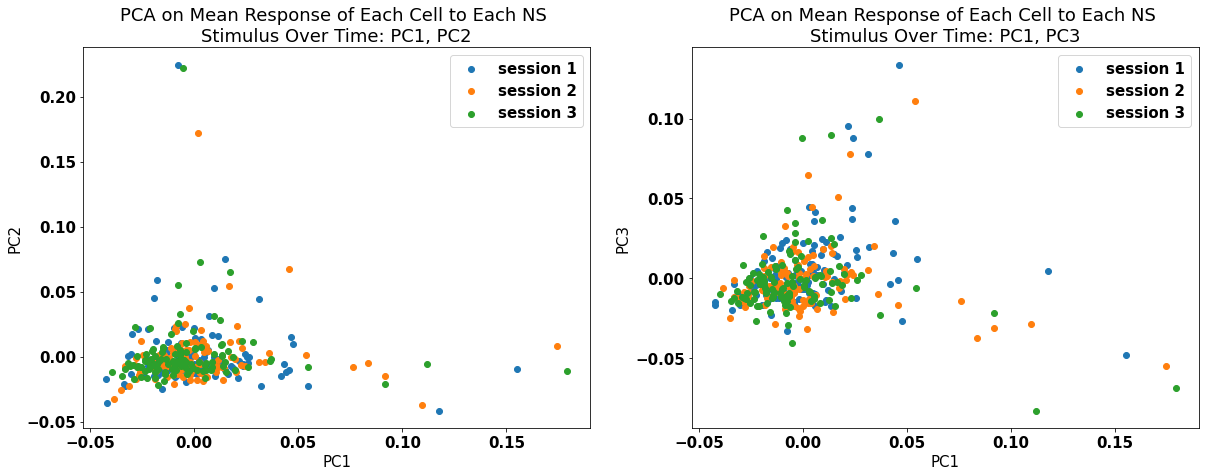

In [17]:
# 2D PCA Visualization: PCs 1, 2
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,7))

ax1.scatter(transformed_data[transformed_data.Session=="1"][0], transformed_data[transformed_data.Session=="1"][1], label="session 1")
ax1.scatter(transformed_data[transformed_data.Session=="2"][0], transformed_data[transformed_data.Session=="2"][1], label="session 2")
ax1.scatter(transformed_data[transformed_data.Session=="3"][0], transformed_data[transformed_data.Session=="3"][1], label="session 3")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_title("PCA on Mean Response of Each Cell to Each NS \nStimulus Over Time: PC1, PC2")


ax2.scatter(transformed_data[transformed_data.Session=="1"][0], transformed_data[transformed_data.Session=="1"][2], label="session 1")
ax2.scatter(transformed_data[transformed_data.Session=="2"][0], transformed_data[transformed_data.Session=="2"][2], label="session 2")
ax2.scatter(transformed_data[transformed_data.Session=="3"][0], transformed_data[transformed_data.Session=="3"][2], label="session 3")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC3")
ax2.set_title("PCA on Mean Response of Each Cell to Each NS \nStimulus Over Time: PC1, PC3")


ax1.legend()
ax2.legend()
plt.show()


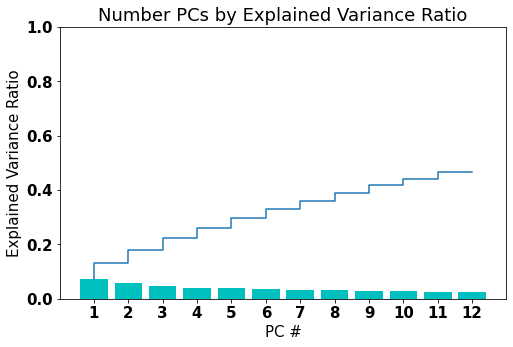

In [18]:
# Number of PCs by explained variance ratio
fig = plt.subplots(figsize=(8,5))
for i in range(1,13):
    plt.bar(i, pca_results.explained_variance_ratio[0][i-1], color="c")
plt.step(range(1,13), np.cumsum(pca_results.explained_variance_ratio[0]))
plt.ylim([0,1])
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.title("Number PCs by Explained Variance Ratio")
plt.xlabel("PC #")
plt.ylabel("Explained Variance Ratio")
# plt.savefig(f"../{desired_container_id}_dg_pca_explained_variance.jpg", dpi=200)
plt.show()

In [19]:
pca_results.explained_variance_ratio[0][0]+pca_results.explained_variance_ratio[0][1]+pca_results.explained_variance_ratio[0][2]

0.1806250583501846

In [20]:
# Separate transformed data dataframe into individual sessions
transformed_data1 = transformed_data[transformed_data.Session=='1']
transformed_data2 = transformed_data[transformed_data.Session=='2']
transformed_data3 = transformed_data[transformed_data.Session=='3']

In [21]:
# Differences between sessions in PC1
diff12_pc1 = transformed_data1[0]-transformed_data2[0]
diff13_pc1 = transformed_data1[0]-transformed_data3[0]
diff23_pc1 = transformed_data2[0]-transformed_data3[0]

# Differences between sessions in PC2
diff12_pc2 = transformed_data1[1]-transformed_data2[1]
diff13_pc2 = transformed_data1[1]-transformed_data3[1]
diff23_pc2 = transformed_data2[1]-transformed_data3[1]

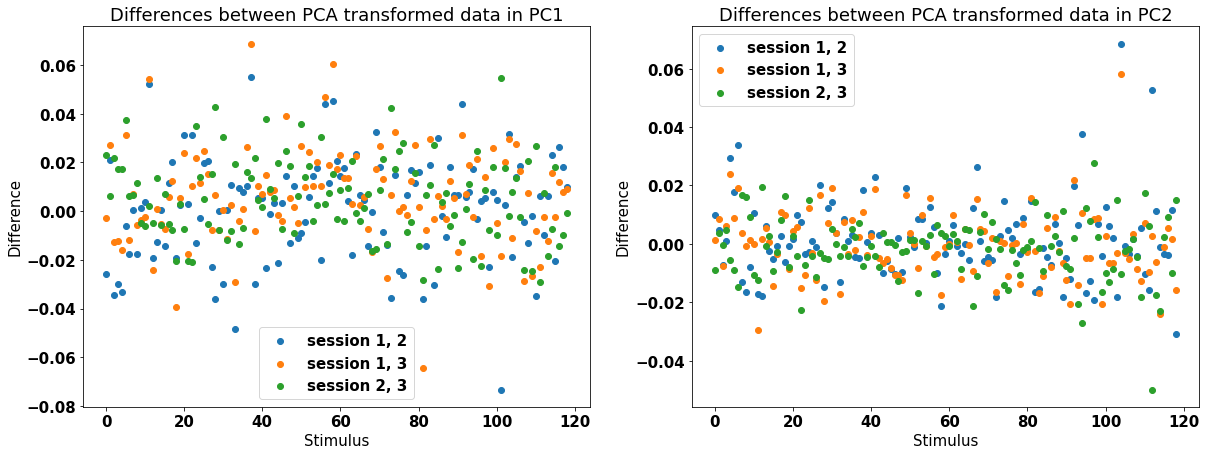

<Figure size 576x360 with 0 Axes>

In [25]:
# Visualize differences in PC1 and PC2 space between sessions
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))
ax1.scatter(range(len(diff12_pc1)), diff12_pc1, label = "session 1, 2")
ax1.scatter(range(len(diff13_pc1)), diff13_pc1, label = "session 1, 3")
ax1.scatter(range(len(diff23_pc1)), diff23_pc1, label = "session 2, 3")
ax1.set_title("Differences between PCA transformed data in PC1")
ax1.set_xlabel("Stimulus")
ax1.set_ylabel("Difference")

# Visualize differences in PC2 space between sessions
fig = plt.figure(figsize=(8,5))
ax2.scatter(range(len(diff12_pc2)), diff12_pc2, label = "session 1, 2")
ax2.scatter(range(len(diff13_pc2)), diff13_pc2, label = "session 1, 3")
ax2.scatter(range(len(diff23_pc2)), diff23_pc2, label = "session 2, 3")
ax2.set_title("Differences between PCA transformed data in PC2")
ax2.set_xlabel("Stimulus")
ax2.set_ylabel("Difference")
ax1.legend()
ax2.legend()

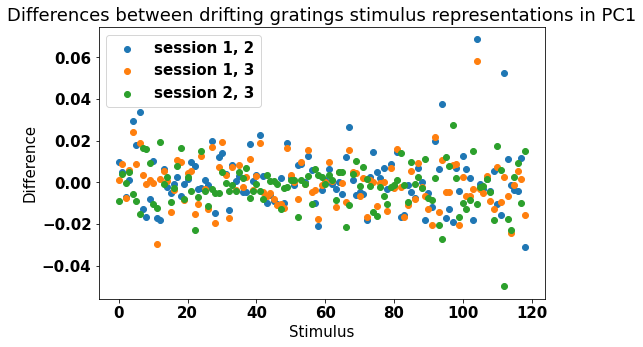

In [23]:
# Visualize differences in PC2 space between sessions
fig = plt.figure(figsize=(8,5))
plt.scatter(range(len(diff12_pc2)), diff12_pc2, label = "session 1, 2")
plt.scatter(range(len(diff13_pc2)), diff13_pc2, label = "session 1, 3")
plt.scatter(range(len(diff23_pc2)), diff23_pc2, label = "session 2, 3")
plt.title("Differences between PCA transformed data in PC2")
plt.xlabel("Stimulus")
plt.ylabel("Difference")
plt.legend()